### Processing monthly DePreSys ###

For the first lead time winter (DJF), we want to collate all of the monthly means and perform the standard fidelity testing method, as in Thompson et al. (2017, doi: 10.1038/s41467-017-00275-3).

For both:

* 2m temperature (with a linear detrend/pivot applied)
* 10m winds or 850hPa winds

First we want to fidelity test the meteorological variables:

* 2m temp (UK land mask)
* 10m wind speed (UK wind grid box)
* 850hPa winds (UK wind grid box)

Then we want to quantify the regression relationships between:

1) monthly mean temperature and weather dependent electricity demand.
2) monthly mean wind speed (10m and 850hPa) and total wind generation

Then use these relationships to translate the model met variables into energy variables.

So we can explore the relationship between winter mean conditions and the likelihood of bad seasons in terms of both the mean state and also the likelihood of seeing extremes.

In [1]:
# Local imports
import os
import sys
import time
import argparse
import calendar

# Third-party imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import shapely.geometry
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import iris

# Specific imports
from tqdm import tqdm
from datetime import datetime, timedelta

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
sys.path.append("/home/users/benhutch/unseen_functions/")
from functions import plot_distributions_fidelity

In [3]:
djf_file_path = '/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/HadGEM3-GC31-MM_tas_United Kingdom_DJF_1960_2018_dcppA-hindcast_Amon.csv'

# check the winters available in this
df = pd.read_csv(djf_file_path)

In [4]:
df.tail()

,init_year,member,lead,data
73745,2018,9,121,279.425814
73746,2018,9,122,275.692171
73747,2018,9,123,275.730993
73748,2018,9,124,278.457006
73749,2018,9,125,277.875223


In [5]:
# import the test file
test_file_path = "/gws/nopw/j04/canari/users/benhutch/dcppA-hindcast/data/tas/HadGEM3-GC31-MM/merged_files/tas_Amon_HadGEM3-GC31-MM_dcppA-hindcast_s1961-r10i1p1f2_gn_196111-197203.nc"

test_cube = iris.load_cube(test_file_path)

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'tas'
  warnings.warn(


In [6]:
test_cube.shape

(125, 324, 432)

In [7]:
# Extract the time coordinate
time_coord = test_cube.coord('time')

# Convert the time points to a human-readable format
time_points = time_coord.units.num2date(time_coord.points)

# Print the time values
for time_point in time_points:
    print(time_point)

1961-11-16 00:00:00
1961-12-16 00:00:00
1962-01-16 00:00:00
1962-02-16 00:00:00
1962-03-16 00:00:00
1962-04-16 00:00:00
1962-05-16 00:00:00
1962-06-16 00:00:00
1962-07-16 00:00:00
1962-08-16 00:00:00
1962-09-16 00:00:00
1962-10-16 00:00:00
1962-11-16 00:00:00
1962-12-16 00:00:00
1963-01-16 00:00:00
1963-02-16 00:00:00
1963-03-16 00:00:00
1963-04-16 00:00:00
1963-05-16 00:00:00
1963-06-16 00:00:00
1963-07-16 00:00:00
1963-08-16 00:00:00
1963-09-16 00:00:00
1963-10-16 00:00:00
1963-11-16 00:00:00
1963-12-16 00:00:00
1964-01-16 00:00:00
1964-02-16 00:00:00
1964-03-16 00:00:00
1964-04-16 00:00:00
1964-05-16 00:00:00
1964-06-16 00:00:00
1964-07-16 00:00:00
1964-08-16 00:00:00
1964-09-16 00:00:00
1964-10-16 00:00:00
1964-11-16 00:00:00
1964-12-16 00:00:00
1965-01-16 00:00:00
1965-02-16 00:00:00
1965-03-16 00:00:00
1965-04-16 00:00:00
1965-05-16 00:00:00
1965-06-16 00:00:00
1965-07-16 00:00:00
1965-08-16 00:00:00
1965-09-16 00:00:00
1965-10-16 00:00:00
1965-11-16 00:00:00
1965-12-16 00:00:00


First DJF winter is lead months 2, 3, and 4. 

In [8]:
# # Subset the dataframe to leads 2, 3, and 4
df_subset = df[df['lead'].isin([12, 13, 14, 15, 16, 17])]

In [9]:
df_subset['lead'].unique()

array([12, 13, 14, 15, 16, 17])

In [10]:
# # Set up a winter years
# winter_years = np.arange(1, 11 + 1)

# # Set up an empty dataframe to store the results
# df_winters = pd.DataFrame()

# # Loop over the winter years
# for i, wyear in enumerate(winter_years):
#     leads_this = np.arange((i * 12) + 2, (i * 12) + 5)

#     # Subset the df to the winter year
#     df_subset = df[df['lead'].isin(leads_this)]

#     # Add a new column for the winter year
#     df_subset['winter_year'] = wyear

#     # concatenate the results
#     df_winters = pd.concat([df_winters, df_subset])

In [12]:
# limit to init years 1960 to 2017
df_subset = df_subset[df_subset['init_year'].isin(range(1960, 2018))]

In [13]:
# set up effective dec year for df_subset
df_subset['effective_dec_year'] = df_subset['init_year'] + 1

In [14]:
df_subset.head()

,init_year,member,lead,data,effective_dec_year
11,1960,10,12,283.084343,1961
12,1960,10,13,278.981183,1961
13,1960,10,14,275.849635,1961
14,1960,10,15,276.140779,1961
15,1960,10,16,276.147612,1961


In [15]:
df_subset["lead"].unique()

array([12, 13, 14, 15, 16, 17])

In [15]:
# # limit the df winters to init years between 1960 and 2017
# df_winters = df_winters[df_winters['init_year'].isin(df_subset["effective_dec_year"].unique())]

In [16]:
# import the obs
obs_path = "/gws/nopw/j04/canari/users/benhutch/unseen/saved_dfs/ERA5_obs_tas_United Kingdom_DJF_1960_2018.csv"

obs_df = pd.read_csv(obs_path)

In [17]:
obs_df.head()

,time,obs
0,1960-12-01,276.477476
1,1961-01-01,275.904981
2,1961-02-01,279.151625
3,1961-03-01,280.353685
4,1961-04-01,281.654381


In [18]:
# limit obs df between 1960-11-31 and 2018-03-01
obs_df = obs_df[(obs_df['time'] >= '1961-09-30') & (obs_df['time'] <= '2018-04-01')]

In [19]:
# Subset to only include months 12, 1, and 2
obs_df['month'] = pd.DatetimeIndex(obs_df['time']).month

obs_df = obs_df[obs_df['month'].isin([10, 11, 12, 1, 2, 3])]

In [20]:
# ensure that time is a valid datetime
obs_df['time'] = pd.to_datetime(obs_df['time'])

In [21]:
def determine_effective_dec_year(row):
    year = row["time"].year
    month = row["time"].month
    if month in [1, 2, 3]:
        return year - 1
    elif month in [10, 11, 12]:
        return year
    else:
        return None
    
obs_df['effective_dec_year'] = obs_df.apply(determine_effective_dec_year, axis=1)

In [22]:
# print the effective dec years in the obs df
obs_df['effective_dec_year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017])

In [23]:
df_subset["effective_dec_year"].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018])

In [24]:
# limit df_subset to the effective dec years in the obs df
df_subset = df_subset[df_subset['effective_dec_year'].isin(obs_df['effective_dec_year'].unique())]

In [25]:
obs_df.tail()

,time,obs,month,effective_dec_year
683,2017-11-01,279.578423,11,2017
684,2017-12-01,277.995927,12,2017
685,2018-01-01,277.697739,1,2017
686,2018-02-01,275.885586,2,2017
687,2018-03-01,277.227535,3,2017


In [26]:
df.head()

,init_year,member,lead,data
0,1960,10,1,279.934728
1,1960,10,2,277.141181
2,1960,10,3,277.110962
3,1960,10,4,277.857627
4,1960,10,5,277.698799


In [28]:
# convert values from K to c
obs_df['tas_c'] = obs_df['obs'] - 273.15
df["tas_c"] = df["data"] - 273.15
df_subset["tas_c"] = df_subset["data"] - 273.15
# df_winters["tas_c"] = df_winters["data"] - 273.15

#### Fidelity testing ####

Our winter is a 3 month block (DJF).

The observed time series consists of 58 winters * 3 months worth of data.

For the fidelity testing we want to select 58 random winters each times.

Choosing a random year.

And a random ensemble member.

In [23]:
# # subset the obs df to only decembers
# obs_df_dec = obs_df[obs_df['month'] == 2]

# # Subset the model to only decembers
# df_dec = df[df['lead'] == 4]

In [26]:
# # process into seasonal DJF means
# obs_df_seasonal = obs_df.groupby(['effective_dec_year']).mean().reset_index()

In [28]:
# # Set up a new dataframe for the model seasonal means
# df_seasonal = pd.DataFrame()

# # Loop over the unique init years
# for init_year in df['init_year'].unique():
#     for member in df['member'].unique():
#         df_subset = df[(df['init_year'] == init_year) & (df['member'] == member)]
#         # select leads 2, 3, and 4
#         df_subset = df_subset[df_subset['lead'].isin([2, 3, 4])]

#         # calculate the mean
#         mean = df_subset['tas_c'].mean()

#         # create a new df
#         df_new = pd.DataFrame(
#             {
#                 'init_year': [init_year],
#                 'member': [member],
#                 'tas_c': [mean]
#             }
#         )

#         # concatenate the results
#         df_seasonal = pd.concat([df_seasonal, df_new])

In [30]:
# # limit the df_seasonal to init years between 1960 and 2017
# df_seasonal = df_seasonal[df_seasonal['init_year'].isin(range(1960, 2018))]

In [29]:
obs_df["month"].unique()

array([10, 11, 12,  1,  2,  3], dtype=int32)

In [30]:
df_subset.head()

,init_year,member,lead,data,effective_dec_year,tas_c
11,1960,10,12,283.084343,1961,9.934343
12,1960,10,13,278.981183,1961,5.831183
13,1960,10,14,275.849635,1961,2.699635
14,1960,10,15,276.140779,1961,2.990779
15,1960,10,16,276.147612,1961,2.997612


In [31]:
df_subset["lead"].unique()

array([12, 13, 14, 15, 16, 17])

the number of unique winters is:  57
the unique times are:  [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974
 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988
 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002
 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016
 2017]
Number of days in a model winter: 6
Number of days to resample for: 342
Unique model times [1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016]


Calculating bootstrap statistics:   0%|          | 7/10000 [00:00<02:26, 68.40it/s]

Calculating bootstrap statistics: 100%|██████████| 10000/10000 [02:23<00:00, 69.62it/s]


(10000,)
shape of obs df obs_val_name:  (342,)


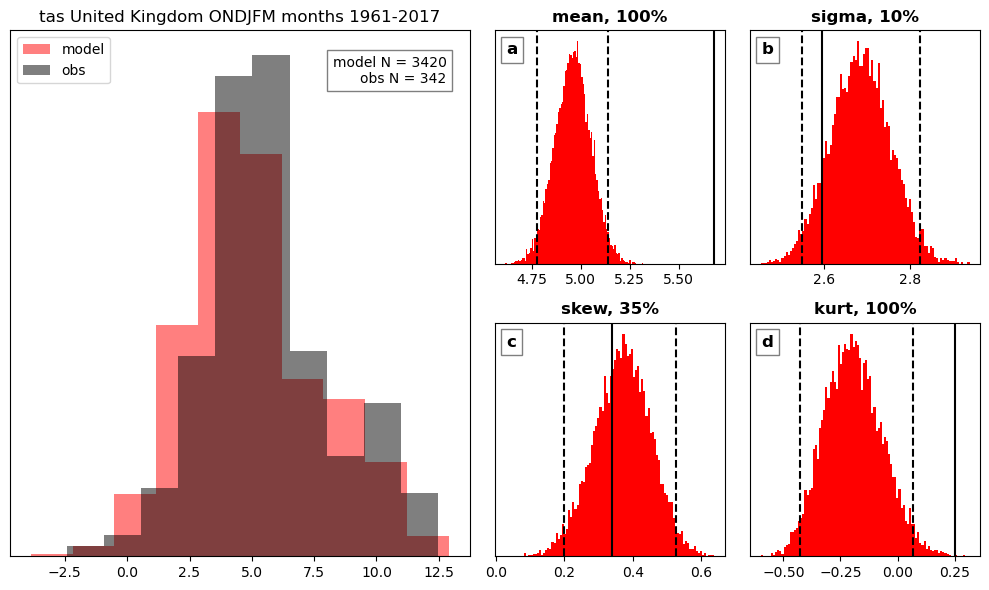

In [33]:
# Plot the distributions and the fidelity
plot_distributions_fidelity(
    obs_df=obs_df,
    model_df=df_subset,
    obs_val_name="tas_c",
    model_val_name="tas_c",
    obs_time_name="effective_dec_year",
    model_time_name="init_year",
    model_member_name="member",
    model_lead_name=None,
    title="tas United Kingdom ONDJFM months 1961-2017",
    nboot=10000,
    figsize=(10, 6),
    nbins=40,
    fname_prefix="tas_United_Kingdom_ONDJFM_months_1960_2017",
)